# Model Setting
  

In [1]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys
# sys.path.append("..")  # 添加上一级目录到sys.path
# from utils import  simulation # 导入module模块
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\RS\AppData\Local\Temp\ipykernel_28336\1309131080.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


In [2]:
# setting the loop location
def get_loop_location(length, angle, offset):

    """
    Get the loop location based on the length and angle
    """
    delta = offset / 2
    locations = []

    # if angle < 90:
    x = length / 2
    y = (length / 2) * np.sin(np.deg2rad(angle))
    z = (length / 2) * np.cos(np.deg2rad(angle))

    locations.append([-delta-x, -y,  z])
    locations.append([-delta+x, -y,  z])
    locations.append([-delta+x,  y, -z])
    locations.append([-delta-x,  y, -z])
    locations.append([-delta-x, -y,  z])

    return np.array(locations)


# 新模型

In [ ]:
def mesh_d(offset, orientation, distance, cell, tunnel_length):
    delta = offset / 2
    dh = cell  # base cell width
    # dom_width = 5000.0  # domain width
    dom_width = 10000
    nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

    # Define the base mesh
    h = [(dh, nbc)]
    mesh = TreeMesh([h, h, h], x0="CCC")
    n = tunnel_length / 2
    for i in range(int(tunnel_length)):
        x_low = -n + i + 0.1 
        # ——————————————————————————y-left——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, -2.3], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————y-right——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [2.4, 2.6], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————z-upper——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, 2.5], [2.4, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————z-lower——————————————————————————————————
    xp, yp, zp = np.meshgrid([-n, n], [-0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    xp, yp, zp = np.meshgrid([-n, n], [0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————Receiver——————————————————————————————————
    # xp, yp, zp = np.meshgrid([0.0, 0.5], [0, 0], [0, 0])
    receiver_locations = np.array([[delta, 0, 0]])

    # Mesh refinement near transmitters and receivers
    # mesh = refine_tree_xyz(
    #     mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
    # )

    if orientation == 'x':
        source_locations = np.array([
            [-delta, -0.5, 0.5], [-delta, 0.5, 0.5], 
            [-delta, 0.5, -0.5], [-delta, -0.5, -0.5],
            [-delta, -0.5, 0.5]])
        
    elif orientation == 'y':
        source_locations = np.array([
            [-delta-0.5, 0, 0.5], [-delta+0.5, 0, 0.5], 
            [-delta+0.5, 0, -0.5], [-delta-0.5, 0, -0.5],
            [-delta-0.5, 0, 0.5]])
    elif orientation == 'z':
        source_locations = np.array([
            [-delta-0.5, -0.5, 0], [-delta-0.5, 0.5, 0], 
            [-delta+0.5, 0.5, 0], [-delta+0.5, -0.5, 0],
            [-delta-0.5, -0.5, 0]])
    else:
        print('orientation error')
        return

    # mesh = refine_tree_xyz(
    #     mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
    # )

    # # ——————————————————————————Abnormal——————————————————————————————————
    x1, y1, z1 = 0, distance+25, 0
    abnormal_locations = np.array(
        [[x1, y1, z1], 
        [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
        [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
        [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
        [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, abnormal_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    mesh.finalize()

    return mesh, source_locations, receiver_locations, abnormal_locations[0]

In [ ]:
def get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, center, tunnel_length, color_type):
    thickness = 0.2

    model = np.ones(mesh.nC) * sigma_half
    mur = np.ones(mesh.nC)

    n = int(tunnel_length/2)
    ################layer####################
    layer = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))

    rail1 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -0.8) & (mesh.gridCC[:,1] <= -0.8 + thickness) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))

    rail2 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= 0.8 - thickness) & (mesh.gridCC[:,1] <= 0.8) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))
    model[layer] = sigma_air
    mur[layer] = 1  


    ################ interference ####################
    for i in range(int(tunnel_length)):
        layer_1 =   ((mesh.gridCC[:,0] >= -n+i) & (mesh.gridCC[:,0] <= -n+i+thickness) & 
                    (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))
        
        model[layer_1] = sigma_frame
        mur[layer_1] = mu_r


    layer_2 =   ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                    (mesh.gridCC[:,1] >= -2.5 + thickness) & (mesh.gridCC[:,1] <= 2.5 - thickness) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5 - thickness))
    model[layer_2] = sigma_air
    mur[layer_2] = 1


    model[rail1] = sigma_rail
    model[rail2] = sigma_rail
    mur[rail1] = mu_r
    mur[rail2] = mu_r
    
    ################ abnormal ####################
    block = (
        (mesh.gridCC[:,0] >= center[0]-25) & (mesh.gridCC[:,0] <= center[0]+25) & 
        (mesh.gridCC[:,1] >= center[1]-25) & (mesh.gridCC[:,1] <= center[1]+25) & 
        (mesh.gridCC[:,2] >= center[2]-25) & (mesh.gridCC[:,2] <= center[2]+25))
    model[block] = sigma_block

    fig = plt.figure(figsize=(10,10), dpi=100)

    opts = {
        'cmap': color_type,
        'linewidths': 0.6}

    plt.subplot(221)
    plt.rcParams["font.family"] = ["Times New Roman"]
    ax1 = plt.gca()
    dat2 = mesh.plotSlice(
        np.log10(model), 
        grid= True , 
        ax=ax1,  
        normal='x', 
        pcolor_opts = opts
    )

    ax1.set_xlim([-3,3])
    ax1.set_ylim([-3,3])
    # ax.set_title("Conductivity profile at X = 0")
    ax1.set_xlabel("Y / m", fontsize=12)
    ax1.set_ylabel("Z / m", fontsize=12)
    ax1.tick_params(labelsize=12)
    ax1.set_title("")

    plt.subplot(222)
    ax2 = plt.gca()
    dat2 = mesh.plotSlice(
        np.log10(model), 
        grid= True , 
        ax=ax2,  
        normal='y', 
        pcolor_opts = opts
    )
    ax2.set_xlim([-3,3])
    ax2.set_ylim([-3,3])
    # ax.set_title("Conductivity profile at Y = 0")
    ax2.set_xlabel("X / m", fontsize=12)
    ax2.set_ylabel("Z / m", fontsize=12)
    ax2.tick_params(labelsize=12)
    ax2.set_title("")

    # plt.savefig('./figure1.eps', dpi=350, bbox_inches="tight")
    plt.savefig('./figure1.tiff', dpi=350, bbox_inches="tight")
    plt.savefig('./figure1.png', dpi=350, bbox_inches="tight")

    return model, mur

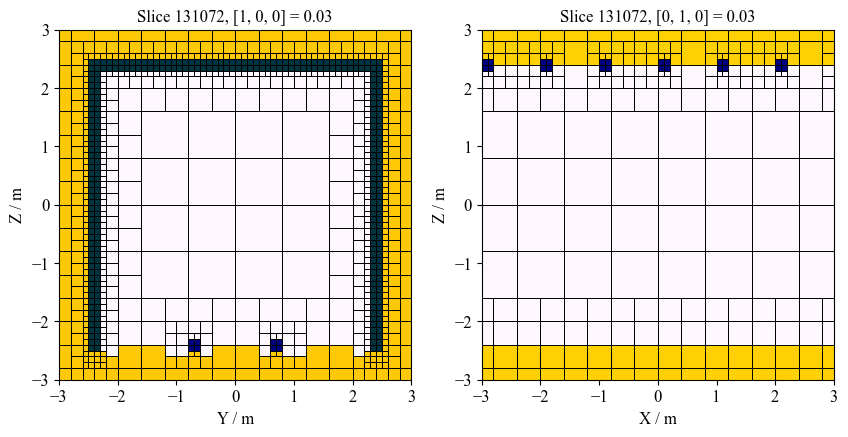

In [97]:
sigma_air = 1e-8
sigma_frame = 5e5
sigma_rail  = 1.25e6
sigma_half = round(1 / 300, 4)
sigma_block = [sigma_half, 1]
dir = ["x", "y", "z"]
mu_r = 100
offset = 0
distance = 50
cell = [0.05]
tunnel_length = 50
color_type = 'gist_ncar_r'
# path = "./data_Src{}_block{}_offset{}_distance{}.npy".format(dir[j], sigma_block[i], offset, distance)
mesh, source_locations, receiver_locations, center = mesh_d(offset, dir[0], distance, cell[0], tunnel_length)
model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[0], sigma_air, center, tunnel_length, color_type)